# Imports



In [5]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import kendalltau, pearsonr
from tabulate import tabulate
import random
import numpy as np
from scipy import stats
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns


# Setting up

In [3]:
main_rul = "https://raw.githubusercontent.com/LevinDana/LLG_full/main/processed_datasets/"

In [6]:
datasets_summary = ["summEval", "poe_8", "cnn_dailyMail_8", "HP_8","ssf","newsroom"]
models_summary = ["phi2_new", "phi3_new", "ncdgzip","llama13_new","llama7_new","llama70_new","rouge_new","blanc","bart_t_s","bertScore","bert","bidirectional_cont_sent", "sentence_random_new"]
data_summary = {}
for model in models_summary:
    data_summary[model] = {}
    for dataset in datasets_summary:
        curr_url = f"{main_rul}/{dataset}/{dataset}_{model}.pkl"
        # Fetch the file content
        response = requests.get(curr_url)
        response.raise_for_status()  # Raise an error if the request failed
        data_summary[model][dataset] = pd.read_pickle(io.BytesIO(response.content))


In [7]:
datasets_para = ["HP_para","cnn_para2","yoda_para"]
models_para = ["phi2_new", "ncdgzip","rouge_new","blanc","bart_t_s","bertScore"]
data_para = {}
for model in models_para:
    data_para[model] = {}
    for dataset in datasets_para:
        curr_url = f"{main_rul}/{dataset}/{dataset}_{model}.pkl"
        # Fetch the file content
        response = requests.get(curr_url)
        response.raise_for_status()  # Raise an error if the request failed
        data_para[model][dataset] = pd.read_pickle(io.BytesIO(response.content))


In [8]:
def bootstrap_get_sample(annotations,llg):
    annotations_new, llg_new = [],[]
    for i in range(len(llg)):
        rand_idx = random.randint(0,len(llg)-1)
        annotations_new.append(annotations[rand_idx])
        llg_new.append(llg[rand_idx])
    return kendalltau(annotations_new, llg_new)[0],pearsonr(annotations_new, llg_new)[0]



def bootstrap(annotations,llg):
    samples_k,samples_p = [],[]
    for _ in range(1000): 
        k,p = bootstrap_get_sample(annotations,llg)
        samples_k.append(k)
        samples_p.append(p)
    return round(np.std(samples_k),3), round(np.std(samples_p),3) 

def extract_list(obj):
    while isinstance(obj, list) and isinstance(obj[0], list):
        obj = obj[0]
    if isinstance(obj, list): return obj
    else: return [obj]

def unpack_list(X):
    if all(isinstance(i, list) and len(i) == 1 for i in X):
        return [i[0] for i in X]
    else:
        return X

In [ ]:


def paired_z_test(mean1, mean2, se1, se2, data_names):
    """
    Perform a Z-test for paired samples.

    Parameters:
    mean1 (float): Mean of the first sample
    mean2 (float): Mean of the second sample
    se1 (float): Standard error of the first sample
    se2 (float): Standard error of the second sample

    """
    # Calculate the Z-statistic
    z_stat = (mean1 - mean2) / np.sqrt(se1**2 + se2**2)
    
    # Calculate the p-value (one-tailed)
    p_value = stats.norm.sf(np.abs(z_stat))  # Using standard normal distribution

    # Return whether the null hypothesis is rejected
    if p_value < 0.05: return False
    else: return True

In [10]:
def generate_full_width_latex_table(model_names, h_values, data_names, cor_type = "kendall"):
    if cor_type == "kendall":
        std_name = "kendall_boot"
        val_name = "kendall_cor"
    elif cor_type ==" pearson":
        std_name = "pearson_boot"
        val_name = "pearson_cor"
        
    k = len(model_names)  # Number of models
    d = len(h_values)  # Number of datasets
    
    # Define the width of each column manually to avoid stretching beyond the page width
    col_width = "c|"  # Split the width based on the number of datasets

    latex_code = r"""
    \begin{table*}[htbp]
    \renewcommand{\arraystretch}{0.9}
    \centering
    \small
    \begin{tabular}{|c|""" + col_width * d + r"""}
        \hline
         \textbf{Measure}
         &""" + " & ".join([f"\\texttt{{{data_names[i]}}}" for i in range(d)]) + r"""\\
         \hline"""

    # Find max Pearson values for each column
    max_corr = [-float('inf')] * d
    max_std = [-float('inf')] * d

    for j in range(d):
        for i in range(k):
            if i < len(h_values[j]):

                cor_value = h_values[j][i][val_name]
                cor_std = h_values[j][i][std_name]
                if cor_value >= max_corr[j]:
                    max_corr[j] = cor_value
                    max_std[j] = cor_std

    for i in range(k):
        corr_values = []
        for j in range(d):
            if i < len(h_values[j]):
                cor_value = h_values[j][i][val_name]
                curr_mean = h_values[j][i][val_name]
                curr_std = h_values[j][i][std_name]
                # Bold the max value
                if h_values[j][i][val_name] == max_corr[j]:
                    cor_value = r"\textbf{" + str(cor_value)+ " (" + str(curr_std)+ ")" + r"}"
                
                elif paired_z_test(curr_mean, max_corr[j], curr_std, max_std[j],data_names[j]):
                    cor_value = r"\textbf{" + str(cor_value) + " (" + str(curr_std)+ ")" + r"}"
                
                else:
                    cor_value = str(cor_value) + " (" + str(curr_std)+ ")"
                
                corr_values.append(cor_value)
            else:
                corr_values.append("")
        
        latex_code += r"""
         \texttt{""" + model_names[i].replace('_', r'\_') + r"""} 
        & """ + " & ".join(corr_values) + r"""\\
         \hline"""
    
    latex_code += r"""
    \end{tabular}
    \caption{Your caption here}
    \end{table*}"""
    
    return latex_code


In [11]:

def cor_with_annotators(df, metric, dim):
  if dim is not None: 
    df["annotations"] = df["annotations"].apply(extract_list)
    annotation_list = df["annotations"].apply(lambda x: x[0][dim]).tolist()
  else:
    annotation_list = df["annotations"].tolist()
    annotation_list = unpack_list(annotation_list)
  if metric == "ncdGzip": score_list = df["ncdGzip"].tolist()
  elif metric == "blanc": score_list = df["blanc"].tolist()
  elif metric == "bart_t_s": score_list = df["bart"].tolist()
  elif metric in ["rouge1","rouge2","rougeL"]: score_list = [item[metric].recall for item in df['rouge']]
  elif metric in ["precision","recall","f1"]: score_list = [item[metric][0] for item in df["bertScore"]]
  else: score_list = df["llg"].apply(lambda x: x[0][metric]).tolist()
  boot_k,boot_p =  bootstrap(annotation_list,score_list)
  return {"kendall_cor":round(kendalltau(annotation_list, score_list)[0],2), "kendall_boot": boot_k,"pearson_cor":round(pearsonr(annotation_list, score_list)[0],2), "pearson_boot": boot_p}

In [12]:
def get_cor_per_model(metrics,models):
    summEval, newsroom, synopsis, poe, cnn, hp, ssf = [],[],[],[],[],[],[]
    for dataset in datasets_summary:
        for metric,model in zip(metrics,models):
            if dataset == "summEval": summEval.append(cor_with_annotators(data_summary[model][dataset],metric,"relevance"))
            if dataset == "newsroom": newsroom.append(cor_with_annotators(data_summary[model][dataset],metric,"informativeness"))
            if dataset == "ssf": ssf.append(cor_with_annotators(data_summary[model][dataset],metric,"coverage"))
            if dataset == "synopsis_8": synopsis.append(cor_with_annotators(data_summary[model][dataset],metric,None))
            if dataset == "cnn_dailyMail_8": cnn.append(cor_with_annotators(data_summary[model][dataset],metric,None))
            if dataset == "poe_8": poe.append(cor_with_annotators(data_summary[model][dataset],metric,None))
            if dataset == "HP_8": hp.append(cor_with_annotators(data_summary[model][dataset],metric,None))
    return(summEval,newsroom, synopsis, poe, cnn,hp, ssf)

In [13]:
def get_cor_per_model_para(metrics,models):
    cnn_p, hp_p, yoda_p = [],[],[]
    for dataset in datasets_para:
        for metric,model in zip(metrics,models):
            if dataset == "cnn_para2": cnn_p.append(cor_with_annotators(data_para[model][dataset],metric,None))
            if dataset == "HP_para": hp_p.append(cor_with_annotators(data_para[model][dataset],metric,None))
            if dataset == "yoda_para": yoda_p.append(cor_with_annotators(data_para[model][dataset],metric,None))

    return cnn_p, hp_p, yoda_p

# Empirical results - method comparison

In [262]:
summEval,newsroom, synopsis, poe, cnn,hp, ssf = get_cor_per_model(["LLG","NLLG","ncdGzip","blanc","bart_t_s","rougeL","precision"],["phi2_new", "phi2_new","ncdgzip","blanc","bart_t_s","rouge_new","bertScore"])

cnn_p, hp_p, yoda_p = get_cor_per_model_para(["LLG","NLLG","ncdGzip","blanc","bart_t_s","rougeL","precision"],["phi2_new", "phi2_new","ncdgzip","blanc","bart_t_s","rouge_new","bertScore"])
h_values = [summEval,newsroom, ssf,cnn,poe,hp,cnn_p, hp_p, yoda_p]
model_names = [r"$\LLG$", r"$\NLLG$", r"$\NCD_\text{gzip}$", "BLANC", "BARTScore", "ROUGUEL", "BERTScore"]

data_names = ["summEval","Newsroom","SFF","CNN","EAPoe","HPotter","CNN-para","HPotter-para","Sentences"]
print(generate_full_width_latex_table(model_names, h_values,data_names))



    \begin{table*}[htbp]
    \renewcommand{\arraystretch}{0.9}
    \centering
    \small
    \begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
        \hline
         \textbf{Measure}
         &\texttt{summEval} & \texttt{Newsroom} & \texttt{SFF} & \texttt{CNN} & \texttt{EAPoe} & \texttt{HPotter} & \texttt{CNN-para} & \texttt{HPotter-para} & \texttt{Sentences}\\
         \hline
         \texttt{$\LLG$} 
        & 0.18 (0.017) & \textbf{0.54 (0.026)} & \textbf{0.26 (0.011)} & \textbf{0.61 (0.01)} & \textbf{0.55 (0.02)} & \textbf{0.6 (0.02)} & 0.4 (0.03) & \textbf{0.32 (0.067)} & 0.7 (0.004)\\
         \hline
         \texttt{$\NLLG$} 
        & 0.15 (0.018) & 0.45 (0.027) & \textbf{0.25 (0.011)} & 0.55 (0.012) & \textbf{0.55 (0.019)} & \textbf{0.61 (0.02)} & 0.68 (0.008) & \textbf{0.34 (0.074)} & \textbf{0.71 (0.001)}\\
         \hline
         \texttt{$\NCD\_\text{gzip}$} 
        & 0.18 (0.017) & 0.44 (0.027) & \textbf{0.26 (0.011)} & 0.45 (0.013) & 0.48 (0.023) & \textbf{0.56 (0.024)} & 0.37 (

# Content VS Structure Tokens

In [263]:
summEval,newsroom, synopsis, poe, cnn,hp, ssf = get_cor_per_model(["LLG","LLG_content","LLG_function"],["phi2_new", "phi2_new","phi2_new"])

cnn_p, hp_p, yoda_p = get_cor_per_model_para(["LLG","LLG_content","LLG_function"],["phi2_new", "phi2_new","phi2_new"])

h_values = [summEval,newsroom, ssf,cnn,poe,hp,cnn_p, hp_p, yoda_p]
model_names = [r"$\LLG$", r"$\LLG_content$", r"$\LLG_function$"]
data_names = ["summEval","Newsroom","SFF","CNN","EAPoe","HPotter","CNN-para","HPotter-para","Sentences"]
print(generate_full_width_latex_table(model_names, h_values,data_names))


    \begin{table*}[htbp]
    \renewcommand{\arraystretch}{0.9}
    \centering
    \small
    \begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
        \hline
         \textbf{Measure}
         &\texttt{summEval} & \texttt{Newsroom} & \texttt{SFF} & \texttt{CNN} & \texttt{EAPoe} & \texttt{HPotter} & \texttt{CNN-para} & \texttt{HPotter-para} & \texttt{Sentences}\\
         \hline
         \texttt{$\LLG$} 
        & \textbf{0.18 (0.018)} & \textbf{0.54 (0.026)} & \textbf{0.26 (0.011)} & \textbf{0.61 (0.01)} & \textbf{0.55 (0.02)} & \textbf{0.6 (0.021)} & \textbf{0.4 (0.031)} & \textbf{0.32 (0.07)} & \textbf{0.7 (0.004)}\\
         \hline
         \texttt{$\LLG\_content$} 
        & \textbf{0.17 (0.017)} & \textbf{0.54 (0.026)} & \textbf{0.27 (0.01)} & \textbf{0.6 (0.011)} & \textbf{0.54 (0.02)} & \textbf{0.59 (0.021)} & \textbf{0.43 (0.029)} & \textbf{0.29 (0.074)} & 0.64 (0.015)\\
         \hline
         \texttt{$\LLG\_function$} 
        & \textbf{0.15 (0.017)} & 0.47 (0.03) & 0.15 (0.011) & 0.3

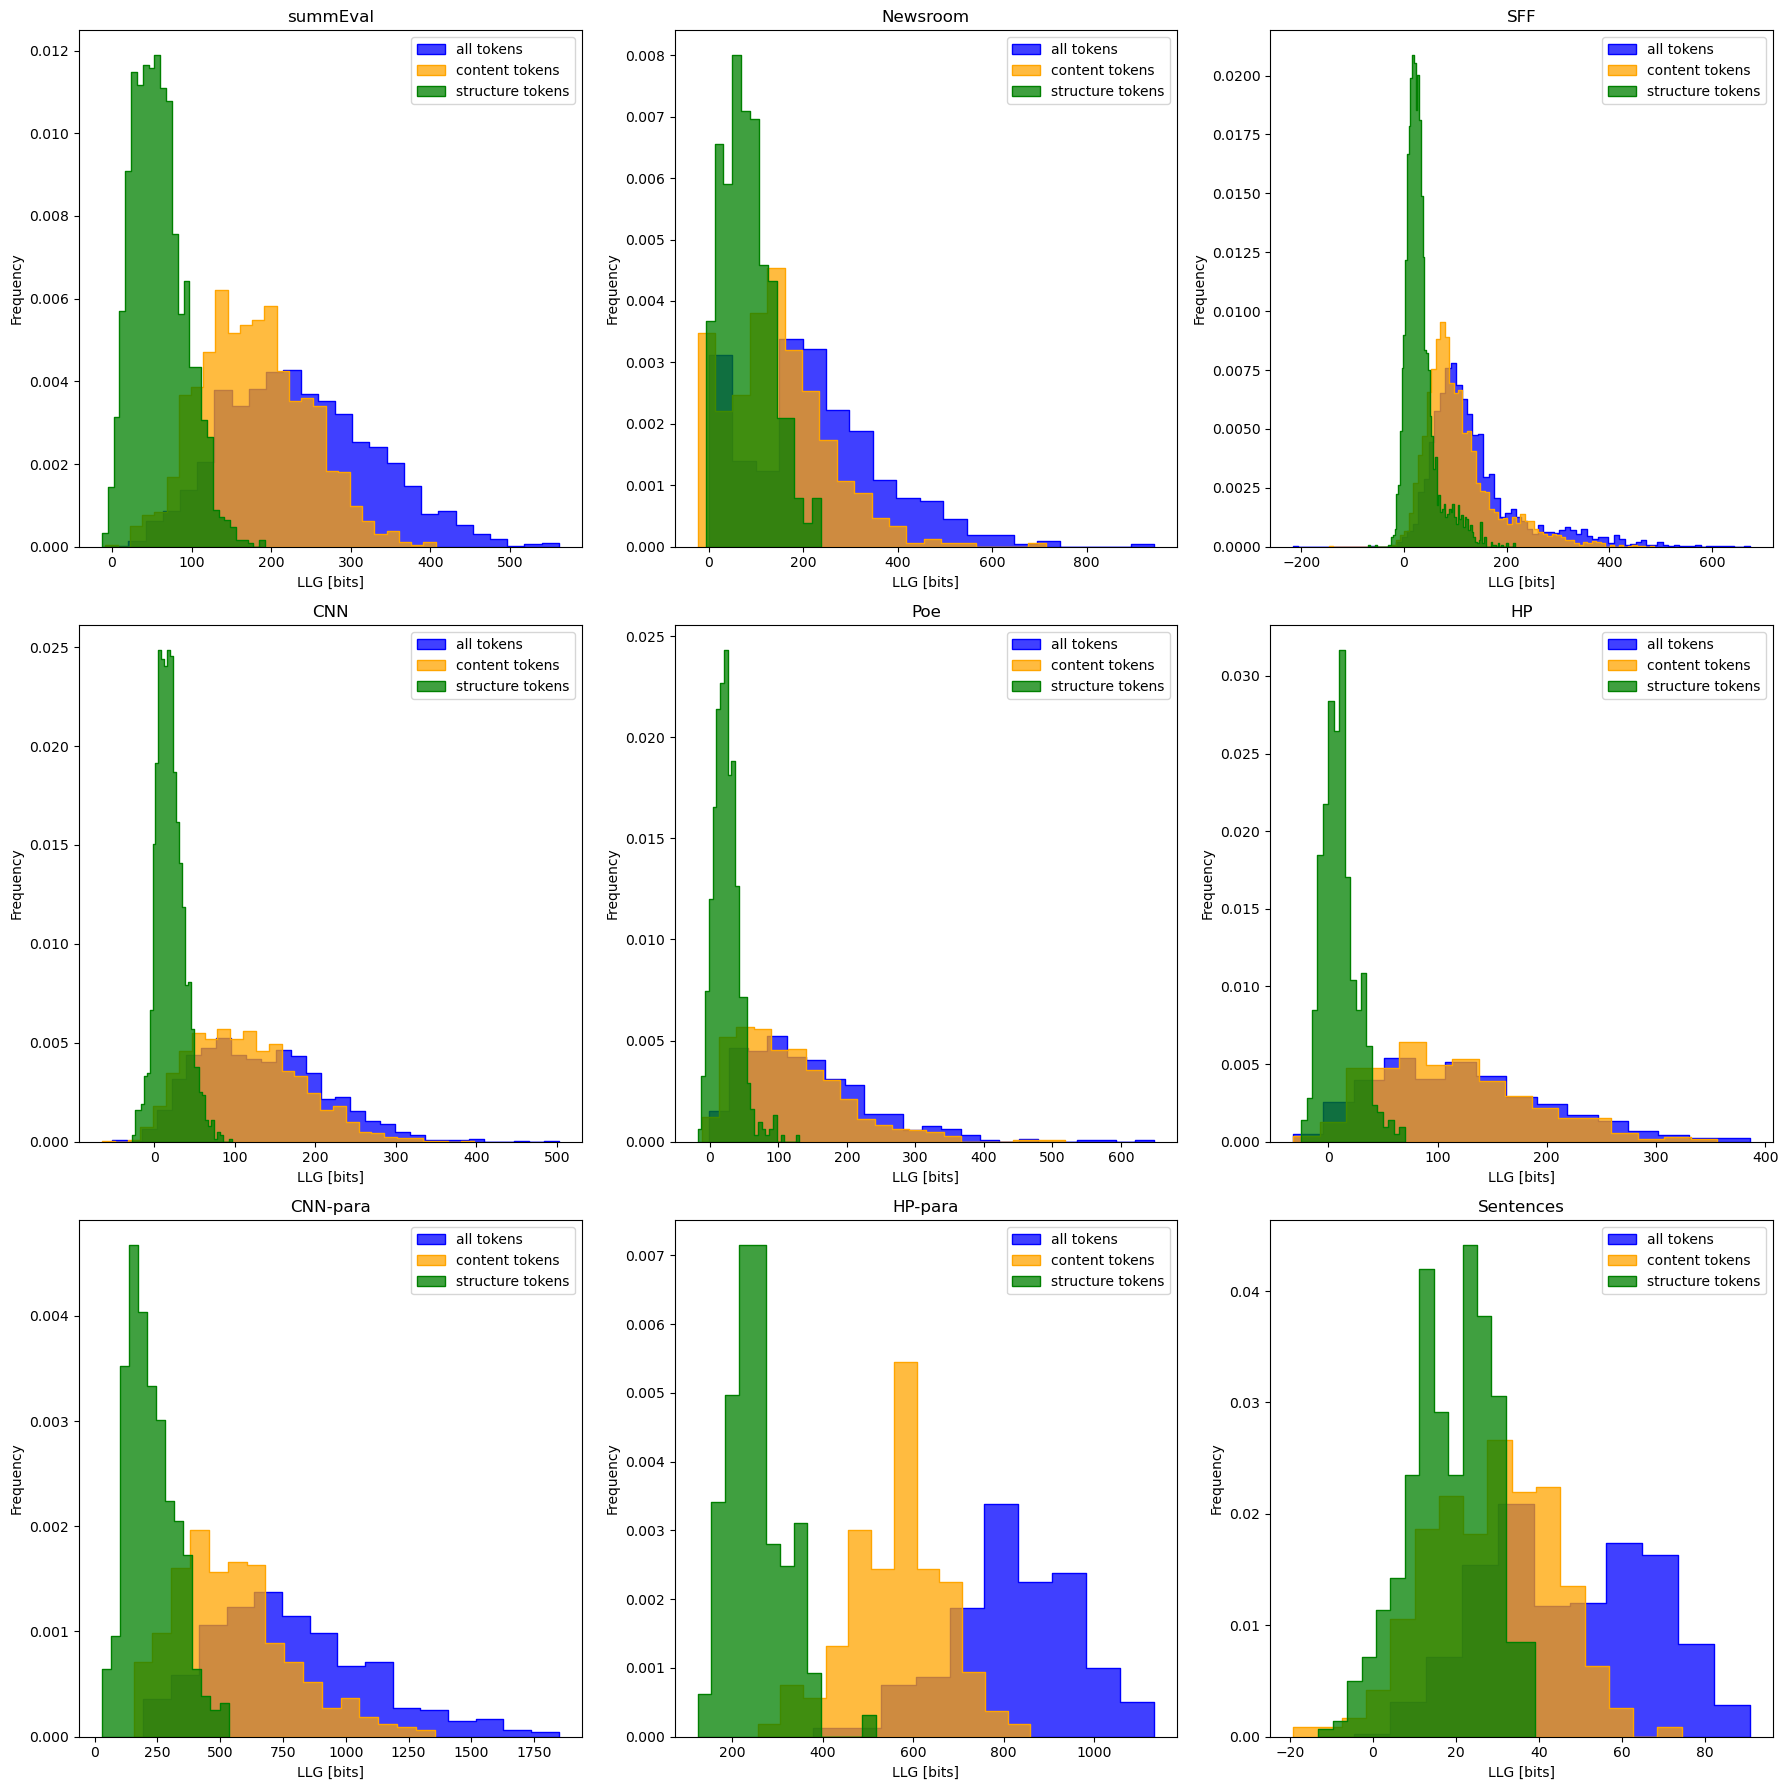

In [21]:
datasets_cf = ["summEval", "poe_8", "cnn_dailyMail_8", "HP_8","ssf","newsroom","HP_para","cnn_para2","yoda_para"]
data_cf = {}
for model in ["phi2_new"]:
    data_cf[model] = {}
    for dataset in datasets_cf:
        curr_url = f"{main_rul}/{dataset}/{dataset}_{model}.pkl"
        # Fetch the file content
        response = requests.get(curr_url)
        response.raise_for_status()  # Raise an error if the request failed
        data_cf[model][dataset] = pd.read_pickle(io.BytesIO(response.content))


datasets = {
    "summEval": "summEval",
    "newsroom": "Newsroom",
    "ssf": "SFF",
    "cnn_dailyMail_8" : "CNN",
    "poe_8": "Poe",
    "HP_8": "HP",
    "cnn_para2":"CNN-para",
    "HP_para": "HP-para",
    "yoda_para":"Sentences"
    
    
}

# Define a function to extract the LLG data
def extract_llg_data(dataset_key):
    llg = data_cf["phi2_new"][dataset_key]["llg"].apply(lambda x: x[0]["LLG"]).tolist()
    llgc = data_cf["phi2_new"][dataset_key]["llg"].apply(lambda x: x[0]["LLG_content"]).tolist()
    llgf = data_cf["phi2_new"][dataset_key]["llg"].apply(lambda x: x[0]["LLG_function"]).tolist()
    return llg, llgc, llgf

# Create the 2x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Loop through the datasets and plot them in the respective subplot
for i, (dataset_key, title) in enumerate(datasets.items()):
    row, col = divmod(i, 3)  # Determine the subplot position
    llg, llgc, llgf = extract_llg_data(dataset_key)
    
    sns.histplot(llg, label='all tokens', ax=axs[row, col], stat="density", element="step", color="blue")
    sns.histplot(llgc, label='content tokens', ax=axs[row, col], stat="density", element="step", color="orange")
    sns.histplot(llgf, label='structure tokens', ax=axs[row, col], stat="density", element="step", color="green")
    axs[row, col].set_xlabel('LLG [bits]')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()
    axs[row, col].set_title(title)

plt.tight_layout()  # Adjusts the spacing between plots
plt.savefig('histogramsIDiff_6plots.pdf', format='pdf', bbox_inches='tight')
plt.show()


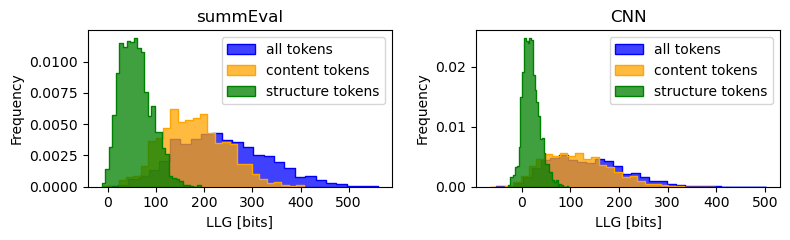

In [30]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

datasets_cf = ["summEval", "cnn_dailyMail_8"]
data_cf = {}



for model in ["phi2_new"]:
    data_cf[model] = {}
    for dataset in datasets_cf:
        curr_url = f"{main_rul}/{dataset}/{dataset}_{model}.pkl"
        # Fetch the file content
        response = requests.get(curr_url)
        response.raise_for_status()  # Raise an error if the request failed
        data_cf[model][dataset] = pd.read_pickle(io.BytesIO(response.content))

datasets = {
    "summEval": "summEval",
    "cnn_dailyMail_8": "CNN",
}

# Function to extract LLG data
def extract_llg_data(dataset_key):
    llg = data_cf["phi2_new"][dataset_key]["llg"].apply(lambda x: x[0]["LLG"]).tolist()
    llgc = data_cf["phi2_new"][dataset_key]["llg"].apply(lambda x: x[0]["LLG_content"]).tolist()
    llgf = data_cf["phi2_new"][dataset_key]["llg"].apply(lambda x: x[0]["LLG_function"]).tolist()
    return llg, llgc, llgf

# Create the 2x1 grid of plots
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))

# Loop through the datasets and plot them in the respective subplot
for i, (dataset_key, title) in enumerate(datasets.items()):
    llg, llgc, llgf = extract_llg_data(dataset_key)
    
    sns.histplot(llg, label='all tokens', ax=axs[i], stat="density", element="step", color="blue")
    sns.histplot(llgc, label='content tokens', ax=axs[i], stat="density", element="step", color="orange")
    sns.histplot(llgf, label='structure tokens', ax=axs[i], stat="density", element="step", color="green")

    axs[i].set_xlabel('LLG [bits]')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].set_title(title)

plt.tight_layout()  # Adjust spacing
plt.savefig('histogramsIDiff_2plots.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Curse of Knowledge Comparison

In [264]:
summEval,newsroom, synopsis, poe, cnn,hp, ssf = get_cor_per_model(["LLG","LLG"],["phi2_new","llama70_new"])
h_values = [summEval,newsroom,ssf,cnn,poe,hp]
model_names = ["Phi-2","LLama 2"]
data_names = ["summEval","Newsroom","SFF","CNN","EAPoe","HPotter"]
print(generate_full_width_latex_table(model_names, h_values,data_names))


    \begin{table*}[htbp]
    \renewcommand{\arraystretch}{0.9}
    \centering
    \small
    \begin{tabular}{|c|c|c|c|c|c|c|}
        \hline
         \textbf{Measure}
         &\texttt{summEval} & \texttt{Newsroom} & \texttt{SFF} & \texttt{CNN} & \texttt{EAPoe} & \texttt{HPotter}\\
         \hline
         \texttt{Phi-2} 
        & \textbf{0.18 (0.018)} & \textbf{0.54 (0.027)} & \textbf{0.26 (0.011)} & \textbf{0.61 (0.011)} & \textbf{0.55 (0.02)} & \textbf{0.6 (0.021)}\\
         \hline
         \texttt{LLama 2} 
        & \textbf{0.18 (0.018)} & \textbf{0.54 (0.026)} & \textbf{0.25 (0.011)} & \textbf{0.59 (0.01)} & -0.02 (0.032) & 0.29 (0.031)\\
         \hline
    \end{tabular}
    \caption{Your caption here}
    \end{table*}


In [266]:
summEval,newsroom, synopsis, poe, cnn,hp, ssf = get_cor_per_model(["LLG","LLG","LLG","LLG","LLG"],["phi2_new","phi3_new" ,"llama7_new","llama13_new","llama70_new"])
h_values = [summEval,newsroom,ssf,cnn,poe,hp]
model_names = ["Phi-2","Phi-3-mini","LLaMA-2-7b-chat","LLaMA-2-13b-chat","LLaMA-2-70b-chat"]
data_names = ["summEval","Newsroom","SFF","CNN","EAPoe","HPotter"]
print(generate_full_width_latex_table(model_names, h_values,data_names))


    \begin{table*}[htbp]
    \renewcommand{\arraystretch}{0.9}
    \centering
    \small
    \begin{tabular}{|c|c|c|c|c|c|c|}
        \hline
         \textbf{Measure}
         &\texttt{summEval} & \texttt{Newsroom} & \texttt{SFF} & \texttt{CNN} & \texttt{EAPoe} & \texttt{HPotter}\\
         \hline
         \texttt{Phi-2} 
        & \textbf{0.18 (0.017)} & \textbf{0.54 (0.026)} & \textbf{0.26 (0.011)} & \textbf{0.61 (0.011)} & \textbf{0.55 (0.02)} & \textbf{0.6 (0.021)}\\
         \hline
         \texttt{Phi-3-mini} 
        & \textbf{0.19 (0.018)} & \textbf{0.55 (0.025)} & \textbf{0.27 (0.011)} & \textbf{0.6 (0.01)} & 0.5 (0.022) & \textbf{0.64 (0.018)}\\
         \hline
         \texttt{LLaMA-2-7b-chat} 
        & \textbf{0.17 (0.017)} & \textbf{0.54 (0.027)} & 0.22 (0.011) & 0.55 (0.012) & 0.44 (0.024) & 0.54 (0.021)\\
         \hline
         \texttt{LLaMA-2-13b-chat} 
        & \textbf{0.18 (0.018)} & \textbf{0.54 (0.026)} & 0.23 (0.011) & 0.55 (0.011) & 0.3 (0.031) & 0.56 (0.022)

In [205]:
with open("curse_of_knowledge_full_scores", "rb") as f:
    df_cok = pickle.load(f)

In [206]:
scores_cuk = df_cok["scores"]
original_total = []
revised_total = []
origial_nonames = []
revised_nonames = []
for score in scores_cuk:
    original_total.append(score["original_total"])
    revised_total.append(score["revised_total"])
    origial_nonames.append(score["nonames_original"])
    revised_nonames.append(score["nonames_revised"])

print("original all tokens loss mean: ", np.mean(original_total) )
print("Revised all tokens loss mean: ", np.mean(revised_total) )
print("original nonames loss mean: ", np.mean(origial_nonames) )
print("Revised nonames loss mean: ", np.mean(revised_nonames) )

print("Loss of altered text is ",round((np.mean(revised_total) - np.mean(original_total))/np.mean(original_total),2), "higher compared to original over all tokens")
print("Loss of altered text is ",round((np.mean(revised_nonames) - np.mean(origial_nonames))/np.mean(origial_nonames),2), "higher compared to original over no name tokens")

original all tokens loss mean:  130.62231055312444
Revised all tokens loss mean:  197.09723170197148
original nonames loss mean:  90.79289364155603
Revised nonames loss mean:  112.89588477305303
Loss of altered text is  0.51 higher compared to original over all tokens
Loss of altered text is  0.24 higher compared to original over no name tokens


In [207]:
print(df_cok.iloc[4]["text"])
print(df_cok.iloc[4]["scores"])

Merry and Pippin reveal they know about the Ring and insist on joining Frodo on his journey.
{'names_original': 35.39148431622834, 'nonames_original': 54.127146230079234, 'original_total': 89.51863054630758, 'names_revised': 61.69722366333008, 'nonames_revised': 75.71860159933567, 'revised_total': 137.41582526266575}


# Content Distillation sentence extraction

In [269]:
gpt4mini = [19,29, 31, 46, 36, 46]
gpt4mini = [item/50 for item in gpt4mini]

gpt4 = [32,33,42,47,42,48]
gpt4 = [item/50 for item in gpt4]

gpt3 = [9,9,12,23,18,30]
gpt3 = [item/50 for item in gpt3]

llg= [44,45,37,39,38,37]
llg = [item/50 for item in llg]

In [270]:
print("gpt3 mean", np.mean(gpt3))
print("gpt3 std", np.std(gpt3))
print("gpt4mini mean", np.mean(gpt4mini))
print("gpt4mini std", np.std(gpt4mini))
print("gpt4o mean", np.mean(gpt4))
print("gpt4o std", np.std(gpt4))
print("llg mean", np.mean(llg))
print("llg std", np.std(llg))

gpt3 mean 0.33666666666666667
gpt3 std 0.15466810344160242
gpt4mini mean 0.69
gpt4mini std 0.19139836293274126
gpt4o mean 0.8133333333333334
gpt4o std 0.12418624006798101
llg mean 0.7999999999999999
llg std 0.06531972647421809


# Bidirectional

In [17]:
data_summary["bidirectional_cont_sent"]["summEval"]

,text,summary,full_annotations,model_id,annotations,llg
0,Paul Merson has restarted his row with Andros ...,paul merson was brought on with only seven min...,"[{'coherence': 2, 'consistency': 1, 'fluency':...",M11,"[{'coherence': 1.3333333333333333, 'consistenc...","[{'LLG': 282.06203847735014, 'NLLG': 0.1778478..."
1,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,"[{'coherence': 3, 'consistency': 5, 'fluency':...",M13,"[{'coherence': 2.3333333333333335, 'consistenc...","[{'LLG': 335.81377227367193, 'NLLG': 0.2117398..."
2,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...",M1,"[{'coherence': 2.3333333333333335, 'consistenc...","[{'LLG': 366.59558659738104, 'NLLG': 0.2311486..."
3,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...",M14,"[{'coherence': 1.6666666666666667, 'consistenc...","[{'LLG': 319.33530178184446, 'NLLG': 0.2013497..."
4,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,"[{'coherence': 4, 'consistency': 5, 'fluency':...",M15,"[{'coherence': 3.3333333333333335, 'consistenc...","[{'LLG': 397.48631752154324, 'NLLG': 0.2506260..."
...,...,...,...,...,...,...
1695,A timewarp home which has remained unchanged s...,"The collector 's paradise in Horfield , Bristo...","[{'coherence': 3, 'consistency': 5, 'fluency':...",M22,"[{'coherence': 3.6666666666666665, 'consistenc...","[{'LLG': 393.3827987948812, 'NLLG': 0.14014217..."
1696,A timewarp home which has remained unchanged s...,"the collector’s paradise in horfield , bristol...","[{'coherence': 5, 'consistency': 5, 'fluency':...",M8,"[{'coherence': 4.0, 'consistency': 5.0, 'fluen...","[{'LLG': 380.71940568278023, 'NLLG': 0.1356308..."
1697,A timewarp home which has remained unchanged s...,"the collector 's paradise in horfield , bristo...","[{'coherence': 3, 'consistency': 5, 'fluency':...",M10,"[{'coherence': 3.3333333333333335, 'consistenc...","[{'LLG': 310.0189026369153, 'NLLG': 0.11044388..."
1698,A timewarp home which has remained unchanged s...,the timewarp home has remained unchanged since...,"[{'coherence': 3, 'consistency': 5, 'fluency':...",M9,"[{'coherence': 2.6666666666666665, 'consistenc...","[{'LLG': 396.37378833194543, 'NLLG': 0.1412077..."


In [20]:
data_summary["bidirectional_cont_sent"]["summEval"].iloc[0]["llg"]

[{'LLG': 282.06203847735014, 'NLLG': 0.17784789489936512}]

In [27]:
summEval,newsroom, synopsis, poe, cnn,hp, ssf = get_cor_per_model(["LLG","LLG","LLG","LLG"],["phi2_new","bert","bidirectional_cont_sent","sentence_random_new"])
h_values = [summEval,newsroom,ssf,cnn,poe,hp]
model_names = ["Phi-2","BERT full content", "BERT sent content", "sentence random"]
data_names = ["summEval","Newsroom","SFF","CNN","EAPoe","HPotter"]
print(generate_full_width_latex_table(model_names, h_values,data_names))


    \begin{table*}[htbp]
    \renewcommand{\arraystretch}{0.9}
    \centering
    \small
    \begin{tabular}{|c|c|c|c|c|c|c|}
        \hline
         \textbf{Measure}
         &\texttt{summEval} & \texttt{Newsroom} & \texttt{SFF} & \texttt{CNN} & \texttt{EAPoe} & \texttt{HPotter}\\
         \hline
         \texttt{Phi-2} 
        & \textbf{0.18 (0.017)} & \textbf{0.54 (0.025)} & \textbf{0.26 (0.011)} & \textbf{0.61 (0.01)} & \textbf{0.55 (0.02)} & \textbf{0.6 (0.021)}\\
         \hline
         \texttt{BERT full content} 
        & 0.13 (0.017) & \textbf{0.5 (0.025)} & 0.22 (0.011) & 0.46 (0.013) & 0.38 (0.025) & 0.5 (0.023)\\
         \hline
         \texttt{BERT sent content} 
        & \textbf{0.14 (0.018)} & 0.46 (0.028) & 0.23 (0.011) & 0.43 (0.014) & 0.37 (0.025) & 0.52 (0.024)\\
         \hline
         \texttt{sentence random} 
        & \textbf{0.14 (0.018)} & 0.44 (0.028) & 0.21 (0.011) & 0.42 (0.014) & 0.37 (0.026) & 0.37 (0.029)\\
         \hline
    \end{tabular}
    \cap